# Imports and Load Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

from shapely import wkt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from shapely.geometry import Point

import contextily as ctx

import geopandas as gpd

In [2]:
data = pd.read_csv("../data/analytics_trip_data_clustering.csv")

# Further Data Preparation and Cleaning

In [3]:
#Further settings for displaying results
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
data.describe()

trip_seconds     trip_miles  pickup_census_tract  \
count  210899.000000  210899.000000         2.108990e+05   
mean      887.603080       4.073999         1.703138e+10   
std       797.246462       5.329247         3.386242e+05   
min        61.000000       0.160000         1.703101e+10   
25%       402.000000       1.000000         1.703108e+10   
50%       601.000000       1.700000         1.703128e+10   
75%      1020.000000       4.000000         1.703183e+10   
max      7181.000000      48.800000         1.703198e+10   

       dropoff_census_tract  pickup_community_area  dropoff_community_area  \
count          2.108990e+05          210889.000000           210092.000000   
mean           1.703134e+10              25.303880               22.146403   
std            3.216965e+05              19.796894               17.166987   
min            1.703101e+10               1.000000                1.000000   
25%            1.703108e+10               8.000000                8.000000   
50%            1.703124e+10              28.000000               24.000000   
75%            1.703183e+10              32.000000               32.000000   
max            1.703198e+10              77.000000               77.000000   

                fare           tips     tolls         extras     trip_total  \
count  210899.000000  210899.000000  167146.0  210899.000000  210899.000000   
mean       14.209048       1.846102       0.0       0.816387      17.015340   
std        16.964388       2.875785       0.0       1.757652      19.275309   
min         0.000000       0.000000       0.0       0.000000       0.000000   
25%         6.500000       0.000000       0.0       0.000000       7.750000   
50%         8.500000       0.000000       0.0       0.000000      10.500000   
75%        14.750000       2.450000       0.0       1.000000      17.250000   
max      5013.710000     113.000000       0.0     400.000000    5013.750000   

       price_per_mile  miles_per_hour    temperature  precipitation  \
count   210894.000000   210899.000000  210899.000000  210899.000000   
mean        14.545198       13.754674      12.107568       0.002787   
std         16.962700        8.313708      11.789433       0.026936   
min          0.010000        1.010526     -22.777778       0.000000   
25%          7.000000        8.250000       2.222222       0.000000   
50%          9.000000       11.109049      10.555556       0.000000   
75%         15.000000       16.624204      22.777778       0.000000   
max       5013.710000       49.985030      35.555556       1.100000   

       sports_event_h3  sports_event_census_tract   poi_h3_res_8  \
count    210899.000000              210899.000000  210899.000000   
mean          0.000863                   0.000024      72.342387   
std           0.029364                   0.004869      48.434416   
min           0.000000                   0.000000       0.000000   
25%           0.000000                   0.000000      28.000000   
50%           0.000000                   0.000000      81.000000   
75%           0.000000                   0.000000     124.000000   
max           1.000000                   1.000000     151.000000   

        poi_h3_res_7   poi_h3_res_6   poi_h3_res_4  poi_census_tract  
count  210899.000000  210899.000000  210899.000000     210899.000000  
mean      329.076003     720.988051    3213.279186          4.562696  
std       186.855577     279.652891     917.224777         13.226386  
min         0.000000       0.000000       9.000000          0.000000  
25%       181.000000     628.000000    3481.000000          0.000000  
50%       345.000000     872.000000    3481.000000          0.000000  
75%       512.000000     872.000000    3481.000000          0.000000  
max       512.000000     872.000000    3481.000000         67.000000

In [5]:
# Check for NaN values
nan_info = data.isna().sum()
print(nan_info)

trip_id                          0
taxi_id                          5
trip_start_timestamp             0
trip_end_timestamp               0
trip_seconds                     0
trip_miles                       0
pickup_census_tract              0
dropoff_census_tract             0
pickup_community_area           10
dropoff_community_area         807
fare                             0
tips                             0
tolls                        43753
extras                           0
trip_total                       0
payment_type                     0
company                          0
pickup_centroid_location         0
dropoff_centroid_location        0
h3_res_4_pickup                  0
h3_res_6_pickup                  0
h3_res_7_pickup                  0
h3_res_8_pickup                  0
h3_res_9_pickup                  0
h3_res_4_dropoff                 0
h3_res_6_dropoff                 0
h3_res_7_dropoff                 0
h3_res_8_dropoff                 0
h3_res_9_dropoff    

Column tolls seems to be useless, as many entries are zero, so we drop it. We also have some values that are missing in price_per_mile, which we also want to drop.

In [6]:
data.drop(columns=['tolls'], inplace=True)
data.dropna(inplace=True)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 210072 entries, 0 to 210898
Data columns (total 42 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   trip_id                    210072 non-null  object 
 1   taxi_id                    210072 non-null  object 
 2   trip_start_timestamp       210072 non-null  object 
 3   trip_end_timestamp         210072 non-null  object 
 4   trip_seconds               210072 non-null  float64
 5   trip_miles                 210072 non-null  float64
 6   pickup_census_tract        210072 non-null  float64
 7   dropoff_census_tract       210072 non-null  float64
 8   pickup_community_area      210072 non-null  float64
 9   dropoff_community_area     210072 non-null  float64
 10  fare                       210072 non-null  float64
 11  tips                       210072 non-null  float64
 12  extras                     210072 non-null  float64
 13  trip_total                 210072 

In [8]:
data.head(1)

trip_id  \
0  55c95a71ea306ad47e2b7c6d72c3efae6adfc263   

                                                                                                                            taxi_id  \
0  4136627ef25b9fad79910c55679c02d8e1f2a42925d29c89625b9a1b45192d184a2a2d368927e2eeccd104c0c21efb24cbe8a9d1c27bc3513911181e1c9ac216   

  trip_start_timestamp   trip_end_timestamp  trip_seconds  trip_miles  \
0  2018-01-01 00:15:00  2018-01-01 00:30:00        1139.0        10.3   

   pickup_census_tract  dropoff_census_tract  pickup_community_area  \
0         1.703183e+10          1.703125e+10                   28.0   

   dropoff_community_area  fare  tips  extras  trip_total payment_type  \
0                    25.0  27.5   0.0     0.0        27.5         Cash   

      company             pickup_centroid_location  \
0  Yellow Cab  POINT (-87.6635175498 41.874005383)   

              dropoff_centroid_location  h3_res_4_pickup  h3_res_6_pickup  \
0  POINT (-87.7560467111 41.8906088526)  842664dffffffff  862664cafffffff   

   h3_res_7_pickup  h3_res_8_pickup  h3_res_9_pickup h3_res_4_dropoff  \
0  872664ca9ffffff  882664ca91fffff  892664ca913ffff  842664dffffffff   

  h3_res_6_dropoff h3_res_7_dropoff h3_res_8_dropoff h3_res_9_dropoff  \
0  862664c87ffffff  872664c80ffffff  882664c80bfffff  892664c80afffff   

  trip_middle_timestamp  price_per_mile  miles_per_hour                 date  \
0   2018-01-01 00:22:30            27.5       32.554873  2018-01-01 01:53:00   

   temperature  precipitation             Game_End  sports_event_h3  \
0   -18.333333            0.0  2018-01-01 00:00:00              0.0   

   sports_event_census_tract  poi_h3_res_8  poi_h3_res_7  poi_h3_res_6  \
0                        0.0          18.0          42.0         574.0   

   poi_h3_res_4  poi_census_tract  
0          3481               2.0

## Adding new Features

### Time Features

In [9]:
data['trip_start_timestamp'] = pd.to_datetime(data['trip_start_timestamp'])
data['hour'] = data['trip_start_timestamp'].dt.hour
data['weekday'] = data['trip_start_timestamp'].dt.weekday
data['month'] = data['trip_start_timestamp'].dt.month

### Sports Data Features

To enhance our analysis, it might be valuable to further differentiate taxi rides based on whether they start at a sports location.

In [10]:
data['pick_from_sport'] = ((data['sports_event_h3'] != 0) | (data['sports_event_census_tract'] != 0)).astype(int)

### POI Data Features

To differentiate between taxi rides that originate from points of interest (POIs) and those that do not, we create a binary dummy variable.

In [11]:
data['pick_from_poi'] = ((data['poi_h3_res_8'] != 0) | (data['poi_census_tract'] != 0)).astype(int)

In [12]:
print(data['pick_from_sport'].sum())
print(data['pick_from_poi'].sum())
print(data['poi_h3_res_8'].describe())

185
204102
count    210072.000000
mean         72.425554
std          48.485134
min           0.000000
25%          28.000000
50%          81.000000
75%         124.000000
max         151.000000
Name: poi_h3_res_8, dtype: float64


Including sports event data does not seem to make much sense, as too few cab journeys can be linked to sports events. With the POI data it seems to be different, almost all trips can be linked to H3 data with Resolution 8. However, this results in another problem, as there are more POIs in a polygon at resolution 8. It becomes challenging to determine definitively whether a given taxi journey is directed towards a specific POI or merely passing through an area with several POIs. For this type of an analysis a more granular resolution would have been needed which in our case was limited due to computational resources.

### Distance to city Center

Separating taxi journeys based on their distance from the city center can provide valuable insights into different journey types and patterns. These distinct categories of journeys may be identified:

   - **City Center to City Center**: Trips that start and end within the city
   - **Out-of-Town to City Center**: Trips that start outside the city center but end within it.
   - **City Center to Out-of-Town**: Trips that start within the city center but end outside it.
   - **Out-of-Town to Out-of-Town**: Trips that neither start nor end within the city center.
   
To measure distances between two geographical points, the Haversine distance is used. Documentation of it can be found [here](https://pypi.org/project/haversine/).


In [13]:
from haversine import haversine_vector, Unit
chicago_coords = (41.8781, -87.6298)

data[['pickup_longitude', 'pickup_latitude']] = data['pickup_centroid_location'].str.extract(r'POINT \(([^ ]+) ([^ ]+)\)').astype(float)
data[['dropoff_longitude', 'dropoff_latitude']] = data['dropoff_centroid_location'].str.extract(r'POINT \(([^ ]+) ([^ ]+)\)').astype(float)

pickup_coords = data[['pickup_latitude', 'pickup_longitude']].values
dropoff_coords = data[['dropoff_latitude', 'dropoff_longitude']].values

chicago_coords_array = np.array([chicago_coords] * len(data))

data['distance_to_chicago'] = haversine_vector(pickup_coords, chicago_coords_array, Unit.MILES)

data['distance_from_chicago'] = haversine_vector(dropoff_coords, chicago_coords_array, Unit.MILES)

data.head(5)

trip_id  \
0  55c95a71ea306ad47e2b7c6d72c3efae6adfc263   
1  02c9a4a90846059404841711508bc085d8a17f8c   
2  27f467cd74c83cfde2bece3317b4d8f2f7aa4f04   
3  114fb9e90f3d1ad81997b9f13cae16d2db6aab6a   
4  0b763e7ec8e51d3cadcba05b8610092c7e96bf7b   

                                                                                                                            taxi_id  \
0  4136627ef25b9fad79910c55679c02d8e1f2a42925d29c89625b9a1b45192d184a2a2d368927e2eeccd104c0c21efb24cbe8a9d1c27bc3513911181e1c9ac216   
1  aad44eec91597fba7477258ddfb9eb5f9968f73a00a381eef558ff18ee14bca531a97ba08981b113b9d4b87c0df0b6778e6dfad6cb9d8538851c658f1b698e70   
2  523c7cc928410364869565991363b5412e81baf6c4dd6922e1ecbd627030f208ba6d57887e9ac93ec89ec62eeb0c3087fa5dc2adfda14488119694e15d03142d   
3  f1726438d397c17b2f21c79e71cde5ff92877f2921eebf4bdc2f1e0300e321e1963eabf2863f7ff0e6ad0e5f8fa511352196506ecc8c68acdb6dd8edadfd6670   
4  95db8e210ca778693bd787eaa7a1a59155613751682d05a1decf61a0f0903d5306138e329d7fd6d4cb7bdeed390af81ad9d628f0cb8d07d61aa207303b8a533d   

  trip_start_timestamp   trip_end_timestamp  trip_seconds  trip_miles  \
0  2018-01-01 00:15:00  2018-01-01 00:30:00        1139.0       10.30   
1  2018-01-01 00:15:00  2018-01-01 00:30:00         535.0        1.94   
2  2018-01-01 00:15:00  2018-01-01 00:30:00         719.0        4.43   
3  2018-01-01 00:15:00  2018-01-01 00:30:00         555.0        0.56   
4  2018-01-01 00:15:00  2018-01-01 00:30:00         594.0        2.00   

   pickup_census_tract  dropoff_census_tract  pickup_community_area  \
0         1.703183e+10          1.703125e+10                   28.0   
1         1.703132e+10          1.703184e+10                   32.0   
2         1.703107e+10          1.703183e+10                    7.0   
3         1.703108e+10          1.703108e+10                    8.0   
4         1.703106e+10          1.703103e+10                    6.0   

   dropoff_community_area   fare  tips  extras  trip_total payment_type  \
0                    25.0  27.50  0.00     0.0       27.50         Cash   
1                    28.0   8.75  0.00     0.0        8.75         Cash   
2                     6.0  14.00  3.88     1.0       19.38  Credit Card   
3                     8.0   6.50  0.00     2.0        8.50         Cash   
4                     3.0   8.75  0.00     1.0        9.75         Cash   

                     company              pickup_centroid_location  \
0                 Yellow Cab   POINT (-87.6635175498 41.874005383)   
1  Nova Taxi Affiliation Llc  POINT (-87.6209929134 41.8849871918)   
2               City Service  POINT (-87.6317173661 41.9146162864)   
3  Chicago Carriage Cab Corp  POINT (-87.6262149064 41.8925077809)   
4                  Flash Cab  POINT (-87.6517705068 41.9426918444)   

              dropoff_centroid_location  h3_res_4_pickup  h3_res_6_pickup  \
0  POINT (-87.7560467111 41.8906088526)  842664dffffffff  862664cafffffff   
1  POINT (-87.6429586652 41.8679024175)  842664dffffffff  862664c1fffffff   
2  POINT (-87.6532439924 41.9528229157)  842664dffffffff  862664c17ffffff   
3  POINT (-87.6197106717 41.8950334495)  842664dffffffff  862664c1fffffff   
4  POINT (-87.6631958495 41.9654457842)  842664dffffffff  862664c17ffffff   

   h3_res_7_pickup  h3_res_8_pickup  h3_res_9_pickup h3_res_4_dropoff  \
0  872664ca9ffffff  882664ca91fffff  892664ca913ffff  842664dffffffff   
1  872664c1effffff  882664c1e3fffff  892664c1e2fffff  842664dffffffff   
2  872664c11ffffff  882664c115fffff  892664c114fffff  842664dffffffff   
3  872664c1effffff  882664c1e1fffff  892664c1e0fffff  842664dffffffff   
4  872664c16ffffff  882664c163fffff  892664c1633ffff  842664dffffffff   

  h3_res_6_dropoff h3_res_7_dropoff h3_res_8_dropoff h3_res_9_dropoff  \
0  862664c87ffffff  872664c80ffffff  882664c80bfffff  892664c80afffff   
1  862664c1fffffff  872664c1affffff  882664c1a7fffff  892664c1a63ffff   
2  862664c17ffffff  872664c16ffffff  882664c169fffff  892664c168fffff   
3  862664c

## Feature Selection

We have focused on numerical features for our analysis and will address geospatial data for kernel density estimation later in the notebook. Variables like trip_id, taxi_id, and date from the weather data join are not relevant for our purposes. Precipitation data is sparse, with the 75th percentile still at 0, so it’s excluded. Similarly, payment_type and company do not provide useful insights into a typical taxi ride, so they are not included either. Instead, we are using fare as a key feature for clustering since it represents the total price of the ride. We will also use other data like temperature, time, day, and month to describe the taxi journey and conditions.

In [14]:
features = ["trip_seconds", "price_per_mile", "miles_per_hour", "trip_miles", "fare", "hour", "weekday", "month","temperature", "distance_to_chicago", "distance_from_chicago"]

In [15]:
Cluster_all = data[features]

In [16]:
Cluster_all.describe()

trip_seconds  price_per_mile  miles_per_hour     trip_miles  \
count  210072.000000   210072.000000   210072.000000  210072.000000   
mean      887.216459       14.526087       13.725141       4.067114   
std       796.910645       16.968797        8.302408       5.324691   
min        61.000000        0.010000        1.010526       0.160000   
25%       401.000000        7.000000        8.250000       1.000000   
50%       601.000000        9.000000       11.076923       1.690000   
75%      1020.000000       15.000000       16.527103       4.000000   
max      7181.000000     5013.710000       49.985030      48.800000   

                fare           hour        weekday          month  \
count  210072.000000  210072.000000  210072.000000  210072.000000   
mean       14.194225      13.865641       2.850385       6.342954   
std        16.970371       5.671562       1.875422       3.339306   
min         0.010000       0.000000       0.000000       1.000000   
25%         6.500000      10.000000       1.000000       3.000000   
50%         8.500000      15.000000       3.000000       6.000000   
75%        14.750000      18.000000       4.000000       9.000000   
max      5013.710000      23.000000       6.000000      12.000000   

         temperature  distance_to_chicago  distance_from_chicago  
count  210072.000000        210072.000000          210072.000000  
mean       12.103057             2.718278               2.533896  
std        11.789314             4.203171               3.339138  
min       -22.777778             0.242878               0.242878  
25%         2.222222             0.657038               0.665807  
50%        10.555556             1.049310               1.292381  
75%        22.777778             1.778238               2.878049  
max        35.555556            16.207510              16.525486

### Converting hours, months, weekday into dummies

In [17]:
Cluster_all_ohe = pd.get_dummies(Cluster_all, columns=["hour", "weekday", "month"], dtype=int)

In [18]:
Cluster_all_ohe.head(1)

trip_seconds  price_per_mile  miles_per_hour  trip_miles  fare  \
0        1139.0            27.5       32.554873        10.3  27.5   

   temperature  distance_to_chicago  distance_from_chicago  hour_0  hour_1  \
0   -18.333333             1.757563               6.551343       1       0   

   hour_2  hour_3  hour_4  hour_5  hour_6  hour_7  hour_8  hour_9  hour_10  \
0       0       0       0       0       0       0       0       0        0   

   hour_11  hour_12  hour_13  hour_14  hour_15  hour_16  hour_17  hour_18  \
0        0        0        0        0        0        0        0        0   

   hour_19  hour_20  hour_21  hour_22  hour_23  weekday_0  weekday_1  \
0        0        0        0        0        0          1          0   

   weekday_2  weekday_3  weekday_4  weekday_5  weekday_6  month_1  month_2  \
0          0          0          0          0          0        1        0   

   month_3  month_4  month_5  month_6  month_7  month_8  month_9  month_10  \
0        0        0        0        0        0        0        0         0   

   month_11  month_12  
0         0         0

In [19]:
Cluster_all_ohe.columns

Index(['trip_seconds', 'price_per_mile', 'miles_per_hour', 'trip_miles',
       'fare', 'temperature', 'distance_to_chicago', 'distance_from_chicago',
       'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12'],
      dtype='object')

## Data Normalisation

In [20]:
columns_to_normalize=['trip_seconds', 'price_per_mile', 'miles_per_hour', 'trip_miles',
       'fare', 'temperature', 'distance_to_chicago', 'distance_from_chicago',
       'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12']

In [21]:
scaler = StandardScaler()
Cluster_all_ohe[columns_to_normalize] = scaler.fit_transform(Cluster_all_ohe[columns_to_normalize])
print(Cluster_all_ohe.columns)

Index(['trip_seconds', 'price_per_mile', 'miles_per_hour', 'trip_miles',
       'fare', 'temperature', 'distance_to_chicago', 'distance_from_chicago',
       'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12'],
      dtype='object')


In [22]:
Cluster_all_ohe.describe()

trip_seconds  price_per_mile  miles_per_hour    trip_miles  \
count  2.100720e+05    2.100720e+05    2.100720e+05  2.100720e+05   
mean   3.517672e-17    9.551833e-17    4.526974e-16 -1.385422e-16   
std    1.000002e+00    1.000002e+00    1.000002e+00  1.000002e+00   
min   -1.036777e+00   -8.554597e-01   -1.531441e+00 -7.337746e-01   
25%   -6.101281e-01   -4.435262e-01   -6.594658e-01 -5.760186e-01   
50%   -3.591584e-01   -3.256625e-01   -3.189706e-01 -4.464333e-01   
75%    1.666233e-01    2.792854e-02    3.374886e-01 -1.260427e-02   
max    7.897747e+00    2.946111e+02    4.367404e+00  8.401050e+00   

               fare   temperature  distance_to_chicago  distance_from_chicago  \
count  2.100720e+05  2.100720e+05         2.100720e+05           2.100720e+05   
mean   5.925925e-17 -1.515305e-16         6.440046e-17          -3.274141e-17   
std    1.000002e+00  1.000002e+00         1.000002e+00           1.000002e+00   
min   -8.358249e-01 -2.958689e+00        -5.889376e-01          -6.861121e-01   
25%   -4.533928e-01 -8.381199e-01        -4.904023e-01          -5.594538e-01   
50%   -3.355400e-01 -1.312634e-01        -3.970745e-01          -3.718078e-01   
75%    3.274981e-02  9.054595e-01        -2.236507e-01           1.030668e-01   
max    2.946033e+02  1.989306e+00         3.209306e+00           4.190191e+00   

             hour_0        hour_1        hour_2        hour_3        hour_4  \
count  2.100720e+05  2.100720e+05  2.100720e+05  2.100720e+05  2.100720e+05   
mean   4.863858e-17 -2.245898e-17  5.060036e-17 -8.303736e-17  1.244715e-17   
std    1.000002e+00  1.000002e+00  1.000002e+00  1.000002e+00  1.000002e+00   
min   -1.555053e-01 -1.379490e-01 -1.224642e-01 -1.028522e-01 -8.548491e-02   
25%   -1.555053e-01 -1.379490e-01 -1.224642e-01 -1.028522e-01 -8.548491e-02   
50%   -1.555053e-01 -1.379490e-01 -1.224642e-01 -1.028522e-01 -8.548491e-02   
75%   -1.555053e-01 -1.379490e-01 -1.224642e-01 -1.028522e-01 -8.548491e-02   
max    6.430647e+00  7.249056e+00  8.165650e+00  9.722690e+00  1.169797e+01   

             hour_5        hour_6        hour_7        hour_8        hour_9  \
count  2.100720e+05  2.100720e+05  2.100720e+05  2.100720e+05  2.100720e+05   
mean  -3.152376e-17  5.722982e-17  2.245898e-17  1.867072e-17  4.309149e-17   
std    1.000002e+00  1.000002e+00  1.000002e+00  1.000002e+00  1.000002e+00   
min   -8.388836e-02 -1.185199e-01 -1.761339e-01 -2.224139e-01 -2.276445e-01   
25%   -8.388836e-02 -1.185199e-01 -1.761339e-01 -2.224139e-01 -2.276445e-01   
50%   -8.388836e-02 -1.185199e-01 -1.761339e-01 -2.224139e-01 -2.276445e-01   
75%   -8.388836e-02 -1.185199e-01 -1.761339e-01 -2.224139e-01 -2.276445e-01   
max    1.192060e+01  8.437398e+00  5.677498e+00  4.496121e+00  4.392814e+00   

            hour_10       hour_11       hour_12       hour_13       hour_14  \
count  2.100720e+05  2.100720e+05  2.100720e+05  2.100720e+05  2.100720e+05   
mean   1.647218e-17  8.760357e-17  1.067478e-16  1.184508e-16  1.178420e-16   
std    1.000002e+00  1.000002e+00  1.000002e+00  1.000002e+00  1.000002e+00   
min   -2.212564e-01 -2.395211e-01 -2.490078e-01 -2.490725e-01 -2.471157e-01   
25%   -2.212564e-01 -2.395211e-01 -2.490078e-01 -2.490725e-01 -2.471157e-01   
50%   -2.212564e-01 -2.395211e-01 -2.490078e-01 -2.490725e-01 -2.471157e-01   
75%   -2.212564e-01 -2.395211e-01 -2.490078e-01 -2.490725e-01 -2.471157e-01   
max    4.519643e+00  4.174997e+00  4.015938e+00  4.014896e+00  4.046688e+00   

            hour_15       hour_16       hour_17       hour_18       hour_19  \
count  2.100720e+05  2.100720e+05  2.100720e+05  2.100720e+05  2.100720e+05   
mean  -4.397090e-17 -7.522407e-17  1.436834e-16  1.106037e-17  1.630306e-17   
std    1.000002e+00  1.000002e+00  1.000002e+00  1.000002e+00  1.000002e+00   
min   -2.555931e-01 -2.681414e-01 -2.785809e-01 -2.754330e-01 -2.580573e-01   
25%   -2.555931e-01 -2.681414e-01 -2.785809e-01 -2.754330e-01 -2.580573e-01   
50%   -2.555931e-01 -2.681414e-01 -2.785809e-

# PCA

(210072, 51)
the total variancein our dataset is 51.00024277506178
the 95% of the variance in our dataset is 48.45023063630869


Text(0, 0.5, '% explained_variance_ratio')

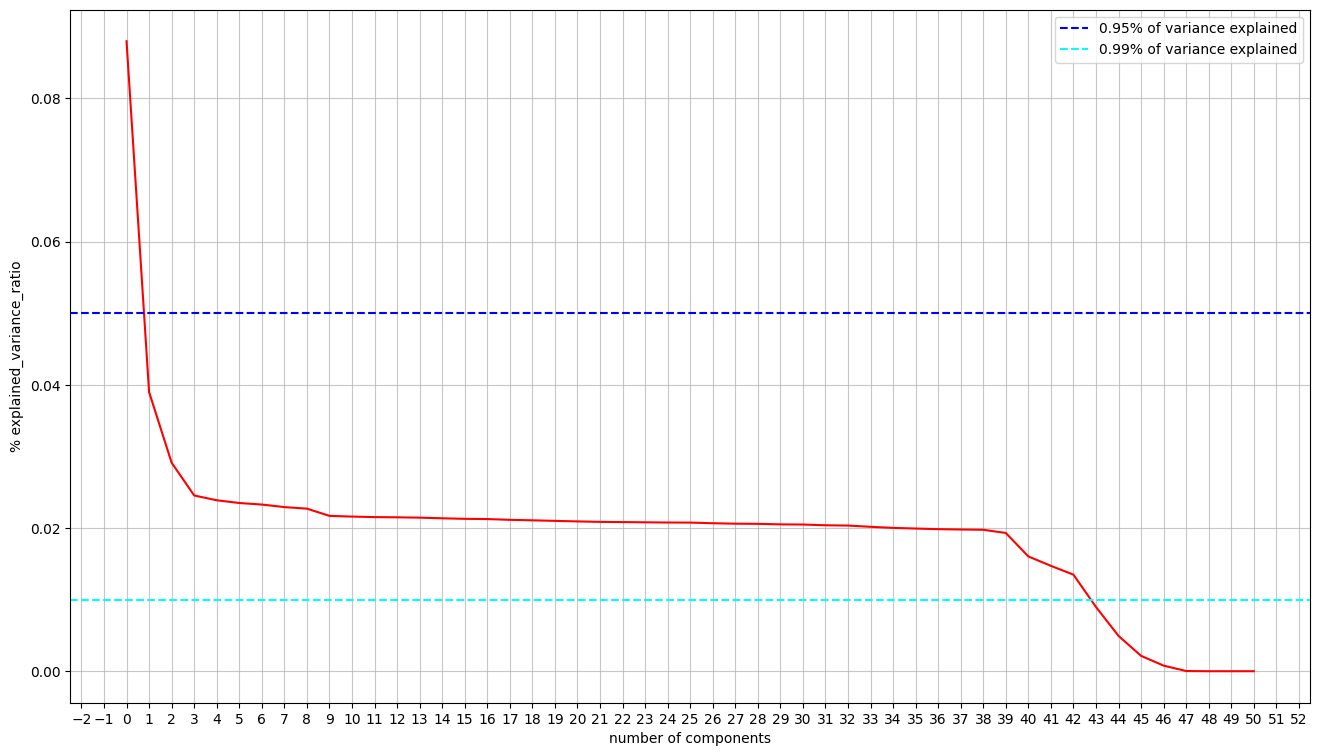

In [23]:
number_comp= Cluster_all_ohe.shape[1]
print(Cluster_all_ohe.shape)
pca= PCA(n_components=number_comp, random_state=47)
X_pca = pca.fit(Cluster_all_ohe).transform(Cluster_all_ohe)

total_variance =sum(pca.explained_variance_)
variance95= total_variance * 0.95
print(f"the total variancein our dataset is {total_variance}")
print(f"the 95% of the variance in our dataset is {variance95}")

a=zip(range(0,number_comp), pca.explained_variance_)
a= pd.DataFrame(a, columns=["PCA Comp", "Explained Variance"])

plt.figure(1, figsize=(16,9))
plt.plot(pca.explained_variance_ratio_, c="r")
tick_step = 1
plt.gca().xaxis.set_major_locator(MultipleLocator(tick_step))
plt.axhline(y=0.05, color='blue', linestyle='--', label='0.95% of variance explained')
plt.axhline(y=0.01, color='cyan', linestyle='--', label='0.99% of variance explained')
plt.grid(True, alpha=0.7)
plt.legend()
plt.xlabel("number of components")
plt.ylabel("% explained_variance_ratio")

## Finding Number of Clusters

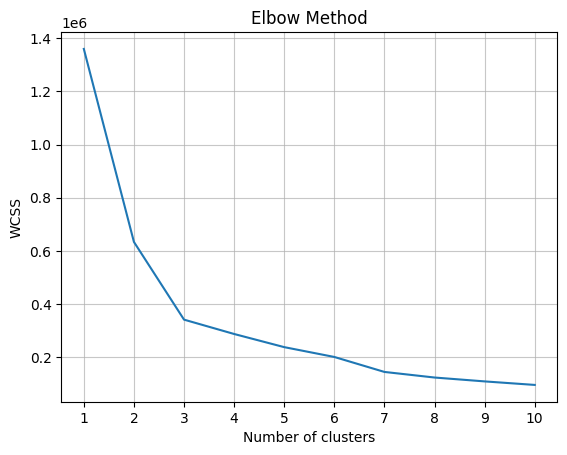

In [24]:
pca= PCA(n_components=2, random_state=47)
X_pca = pca.fit(Cluster_all_ohe).transform(Cluster_all_ohe)

wcss = []  # Within-Cluster-Sum-of-Squares

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

# Plot the Elbow graph
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
tick_step = 1
plt.gca().xaxis.set_major_locator(MultipleLocator(tick_step))
plt.grid(True, alpha=0.7)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # Within-Cluster-Sum-of-Squares
plt.show()

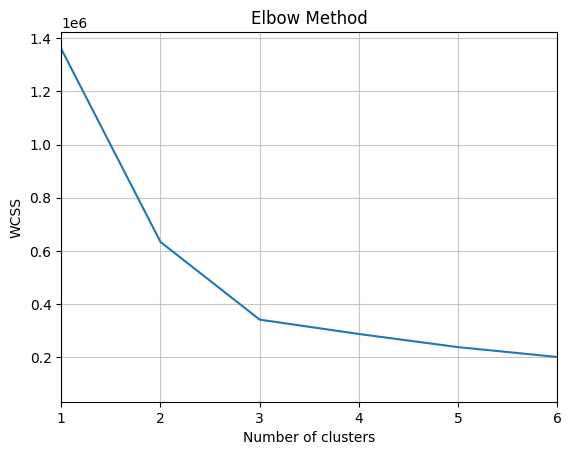

In [25]:
# Plot the Elbow graph
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
tick_step = 1
plt.gca().xaxis.set_major_locator(MultipleLocator(tick_step))
plt.grid(True, alpha=0.7)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # Within-Cluster-Sum-of-Squares
plt.xlim([1,6])
plt.show()

# Hard Clustering

In [26]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=21)
kmeans.fit(X_pca)

KMeans(n_clusters=3, random_state=21)

In [27]:
labels_hard = kmeans.labels_

sample_size = int(0.1 * len(X_pca))

random_indices = np.random.choice(len(X_pca), sample_size, replace=False)
X_pca_sample = X_pca[random_indices]
labels_hard_sample = labels_hard[random_indices]

silhouette_score_hard = silhouette_score(X_pca_sample, labels_hard_sample)
# Calculate the silhouette score for c_raw2
#silhouette_score_hard = silhouette_score(X_pca, labels_hard)
print(f"Silhouette Score for 3 clusters: {silhouette_score_hard}")

Silhouette Score for 3 clusters: 0.5585072887909646


In [28]:
Cluster_all_knn = Cluster_all.copy()
Cluster_all_knn["clusters"]= labels_hard

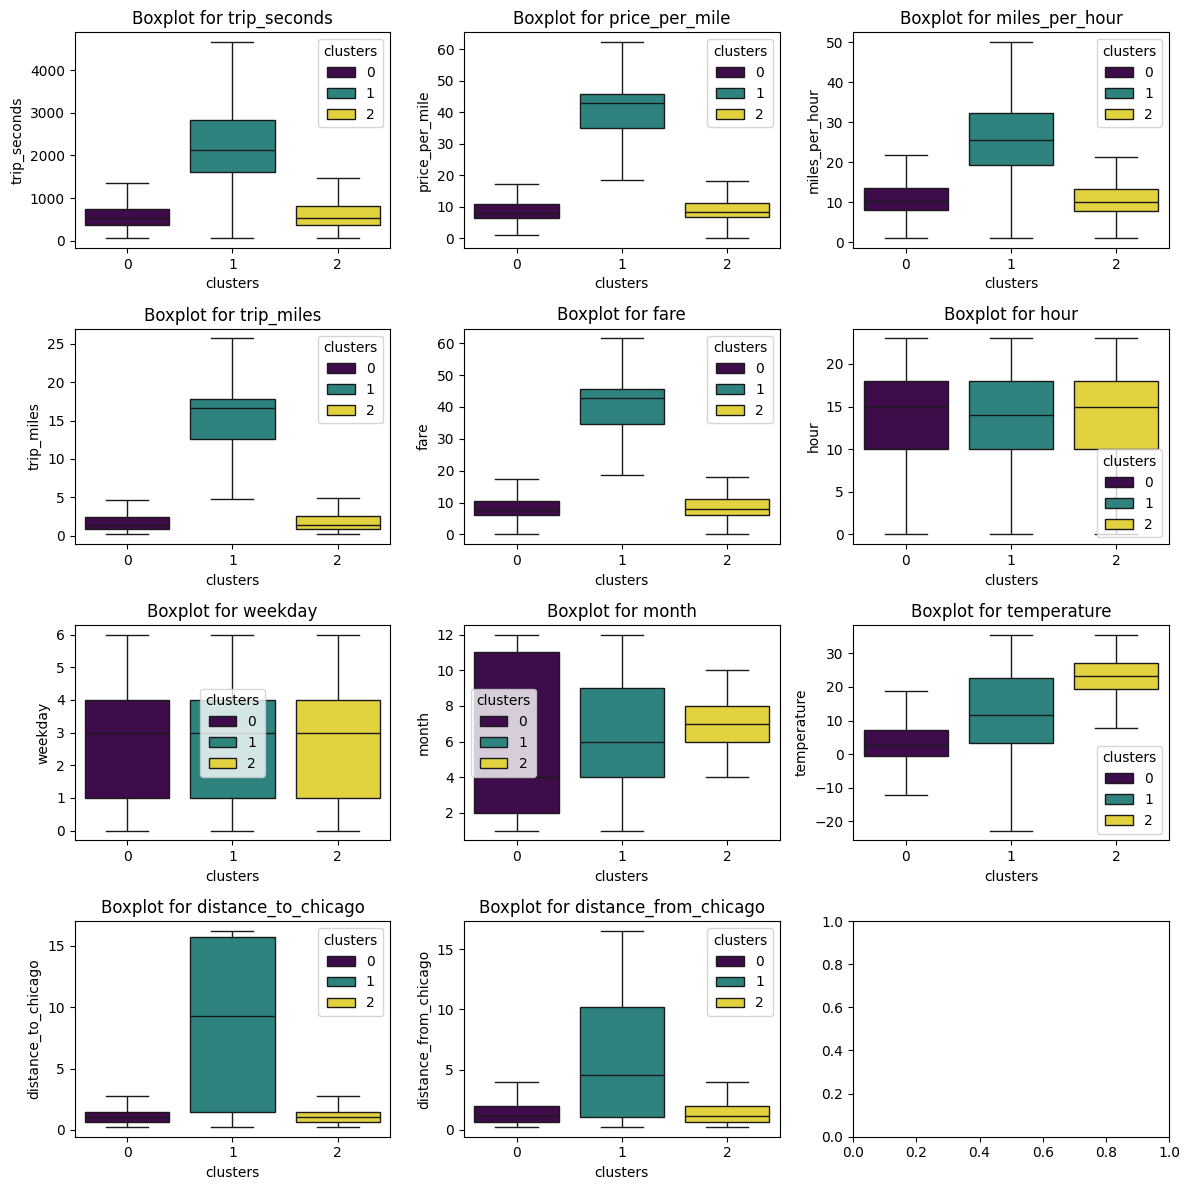

In [29]:
features_hard = features
# Create a 3x3 subplot grid
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 12))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate through features and create boxplots
for i, feature in enumerate(features_hard):
    
    sns.boxplot(x='clusters', y=feature, data=Cluster_all_knn, hue='clusters', palette='viridis', ax=axes[i], showfliers=False)
    
    # Set subplot title
    axes[i].set_title(f'Boxplot for {feature}')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

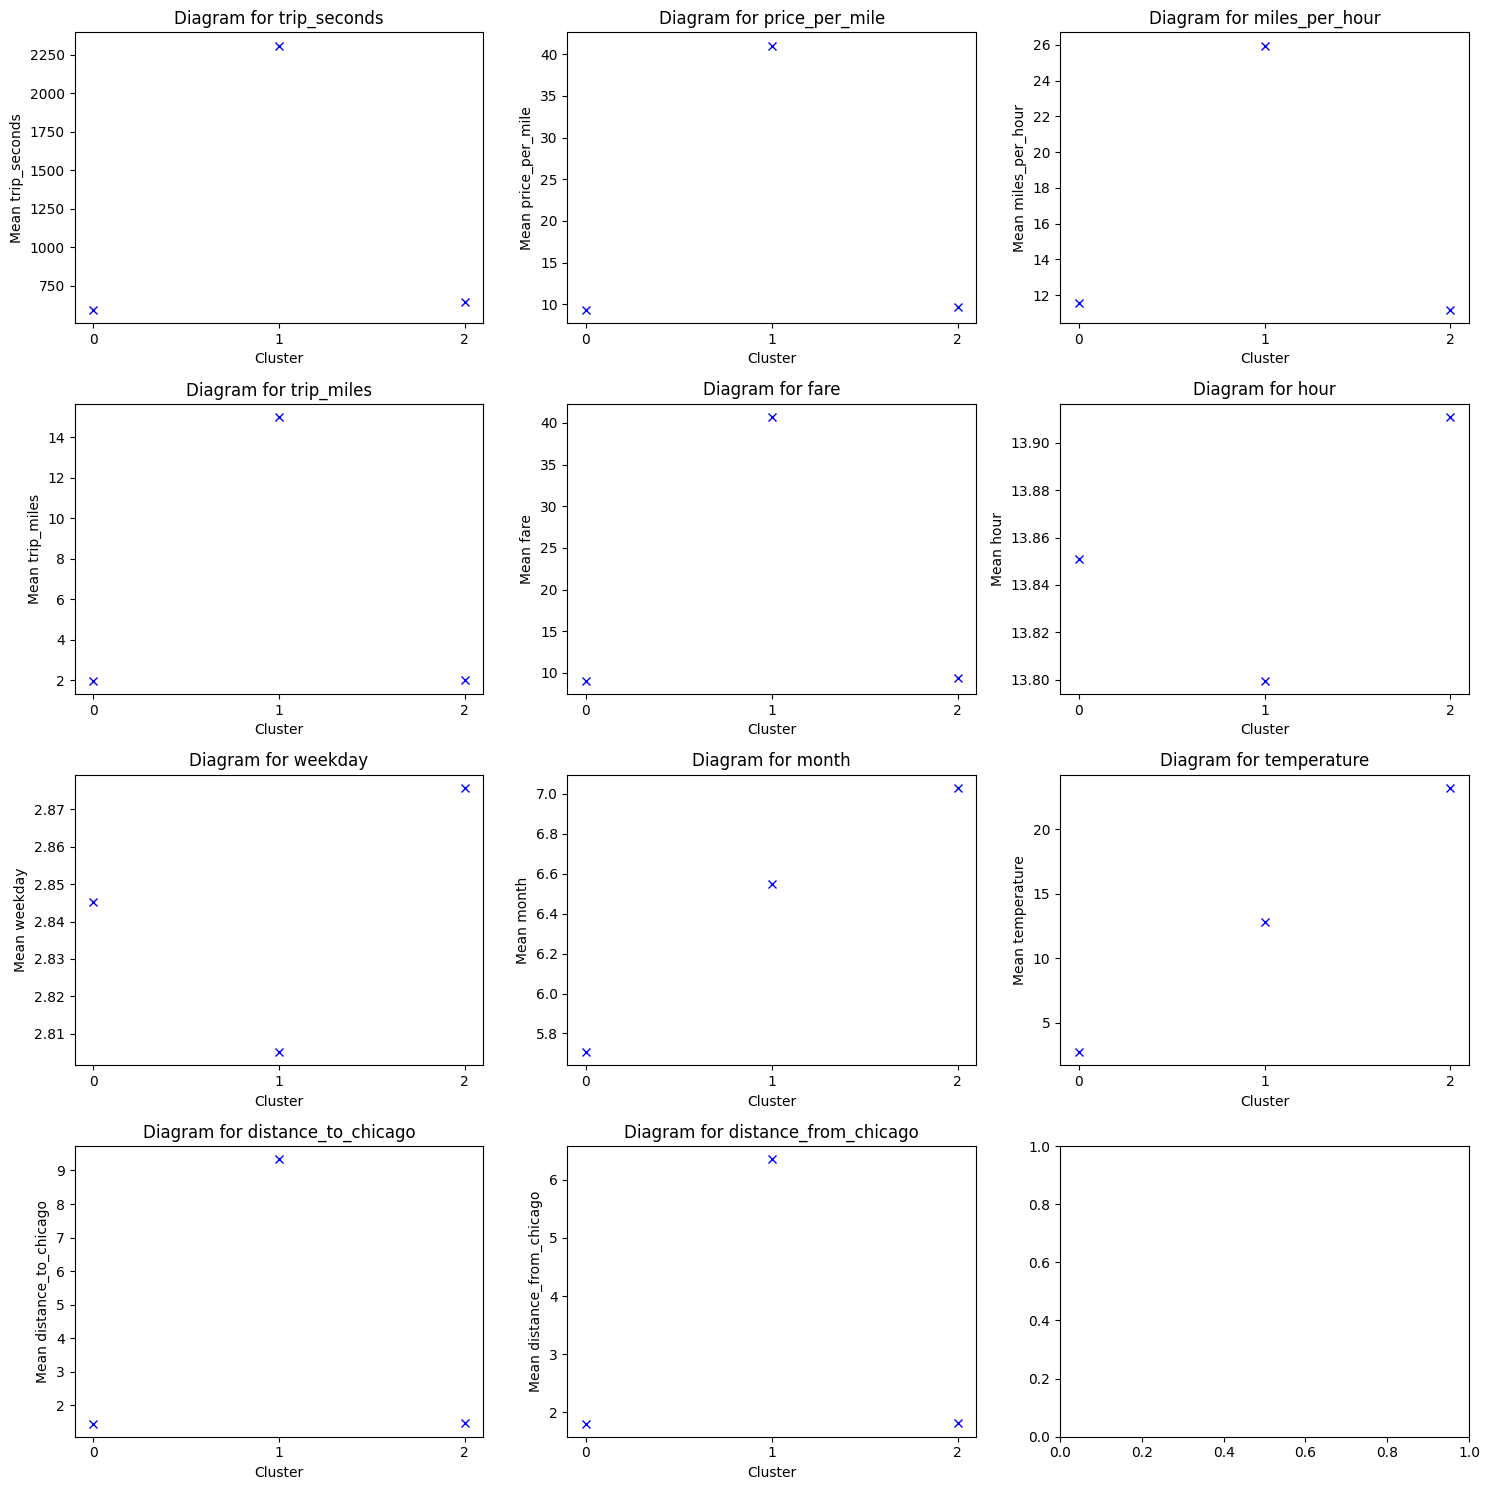

In [30]:
# Features to plot
features_hard = features

cluster_centers = Cluster_all_knn.groupby('clusters').mean().reset_index()

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))

axes = axes.flatten()


for i, feature in enumerate(features_hard):
    axes[i].plot(cluster_centers['clusters'], cluster_centers[feature], marker='x', linestyle='', color='b', label=f'Feature: {feature}')
    
    axes[i].set_title(f'Diagram for {feature}')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(f'Mean {feature}')
    axes[i].xaxis.set_major_locator(MultipleLocator(1))

plt.tight_layout()

plt.show()

In [31]:
# Inspect mean values
cluster_centers

clusters  trip_seconds  price_per_mile  miles_per_hour  trip_miles  \
0         0    595.555462        9.358815       11.590395    1.967044   
1         1   2310.833757       41.021462       25.967814   15.016813   
2         2    644.490714        9.693153       11.186217    2.027011   

        fare       hour   weekday     month  temperature  distance_to_chicago  \
0   9.032569  13.851000  2.845135  5.706159     2.709665             1.452262   
1  40.722233  13.799396  2.805018  6.547175    12.777894             9.333731   
2   9.340852  13.911050  2.875705  7.027528    23.178892             1.482355   

   distance_from_chicago  
0               1.810179  
1               6.351099  
2               1.812540

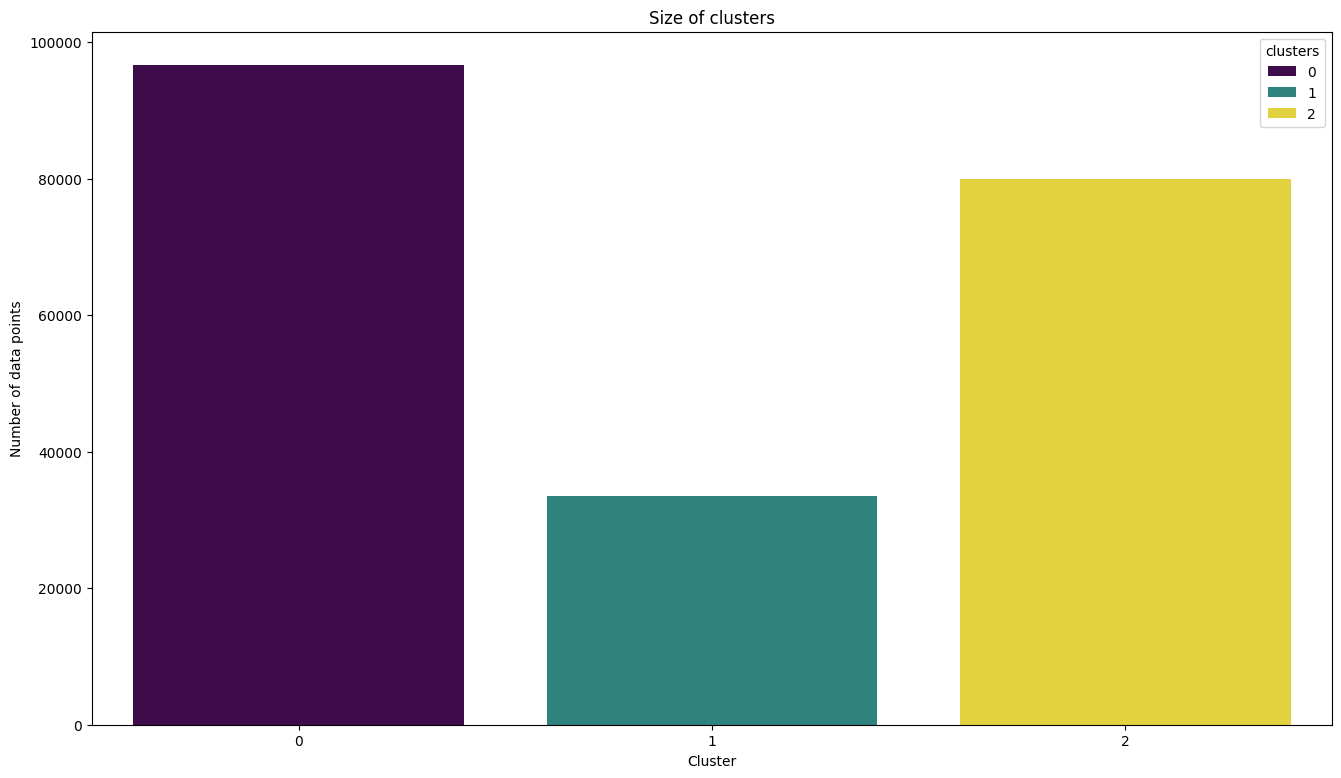

In [32]:
plt.figure(figsize=(16,9))
sns.countplot(data=Cluster_all_knn, x="clusters", hue="clusters", palette='viridis')
plt.xlabel('Cluster')
plt.ylabel('Number of data points')
plt.title('Size of clusters')
plt.show()

In [33]:
cluster_sizes = Cluster_all_knn['clusters'].value_counts()
cluster_sizes

clusters
0    96678
2    79955
1    33439
Name: count, dtype: int64

In [34]:
Cluster_all_knn.describe()

trip_seconds  price_per_mile  miles_per_hour     trip_miles  \
count  210072.000000   210072.000000   210072.000000  210072.000000   
mean      887.216459       14.526087       13.725141       4.067114   
std       796.910645       16.968797        8.302408       5.324691   
min        61.000000        0.010000        1.010526       0.160000   
25%       401.000000        7.000000        8.250000       1.000000   
50%       601.000000        9.000000       11.076923       1.690000   
75%      1020.000000       15.000000       16.527103       4.000000   
max      7181.000000     5013.710000       49.985030      48.800000   

                fare           hour        weekday          month  \
count  210072.000000  210072.000000  210072.000000  210072.000000   
mean       14.194225      13.865641       2.850385       6.342954   
std        16.970371       5.671562       1.875422       3.339306   
min         0.010000       0.000000       0.000000       1.000000   
25%         6.500000      10.000000       1.000000       3.000000   
50%         8.500000      15.000000       3.000000       6.000000   
75%        14.750000      18.000000       4.000000       9.000000   
max      5013.710000      23.000000       6.000000      12.000000   

         temperature  distance_to_chicago  distance_from_chicago  \
count  210072.000000        210072.000000          210072.000000   
mean       12.103057             2.718278               2.533896   
std        11.789314             4.203171               3.339138   
min       -22.777778             0.242878               0.242878   
25%         2.222222             0.657038               0.665807   
50%        10.555556             1.049310               1.292381   
75%        22.777778             1.778238               2.878049   
max        35.555556            16.207510              16.525486   

            clusters  
count  210072.000000  
mean        0.920394  
std         0.913503  
min         0.000000  
25%         0.000000  
50%         1.000000  
75%         2.000000  
max         2.000000

In [35]:
# Intervals based on distribution but not directly adopted
# Trip Duration: long, middle, short
Cluster_all_knn['trip_duration_category'] = [
    'short' if x < 300 else 'middle' if x < 1000 else 'long' 
    for x in Cluster_all_knn['trip_seconds']
]

# Price per Mile: expensive, middle, cheap
Cluster_all_knn['price_per_mile_category'] = [
    'cheap' if x < 9.9 else 'middle' if x < 16.0 else 'expensive' 
    for x in Cluster_all_knn['price_per_mile']
]

# Miles per Hour: fast, middle, slow
Cluster_all_knn['miles_per_hour_category'] = [
    'slow' if x < 13 else 'middle' if x < 30 else 'fast' 
    for x in Cluster_all_knn['miles_per_hour']
]

# Trip Miles: long, middle, short
Cluster_all_knn['trip_miles_category'] = [
    'short' if x < 1.2 else 'middle' if x < 3.1 else 'long' 
    for x in Cluster_all_knn['trip_miles']
]

# Hour: night, morning, noon, afternoon, evening
Cluster_all_knn['hour_category'] = [
    'night' if x < 5 else 
    'morning' if x < 11 else 
    'noon' if x < 14 else 
    'afternoon' if x < 17 else 
    'evening'
    for x in Cluster_all_knn['hour']
]

# Weekday: weekday, weekend
Cluster_all_knn['weekday_category'] = [
    'weekend' if day >= 5 else 'weekday' 
    for day in Cluster_all_knn['weekday']
]

# Month: winter, spring, summer, fall
Cluster_all_knn['month_category'] = [
    'winter' if x in [12, 1, 2] else 'spring' if x in [3, 4, 5] else 'summer' if x in [6, 7, 8] else 'fall' 
    for x in Cluster_all_knn['month']
]

# Temperature: hot, mild, cold
Cluster_all_knn['temperature_category'] = [
    'cold' if x < 4.0 else 'mild' if x < 22.0 else 'hot' 
    for x in Cluster_all_knn['temperature']
]

# Distance to Chicago: near, middle, far
Cluster_all_knn['distance_to_chicago_category'] = [
    'near' if x < 0.7 else 'middle' if x < 3 else 'far' 
    for x in Cluster_all_knn['distance_to_chicago']
]

# Distance from Chicago: near, middle, far
Cluster_all_knn['distance_from_chicago_category'] = [
    'near' if x < 0.7 else 'middle' if x < 3 else 'far' 
    for x in Cluster_all_knn['distance_to_chicago']
]

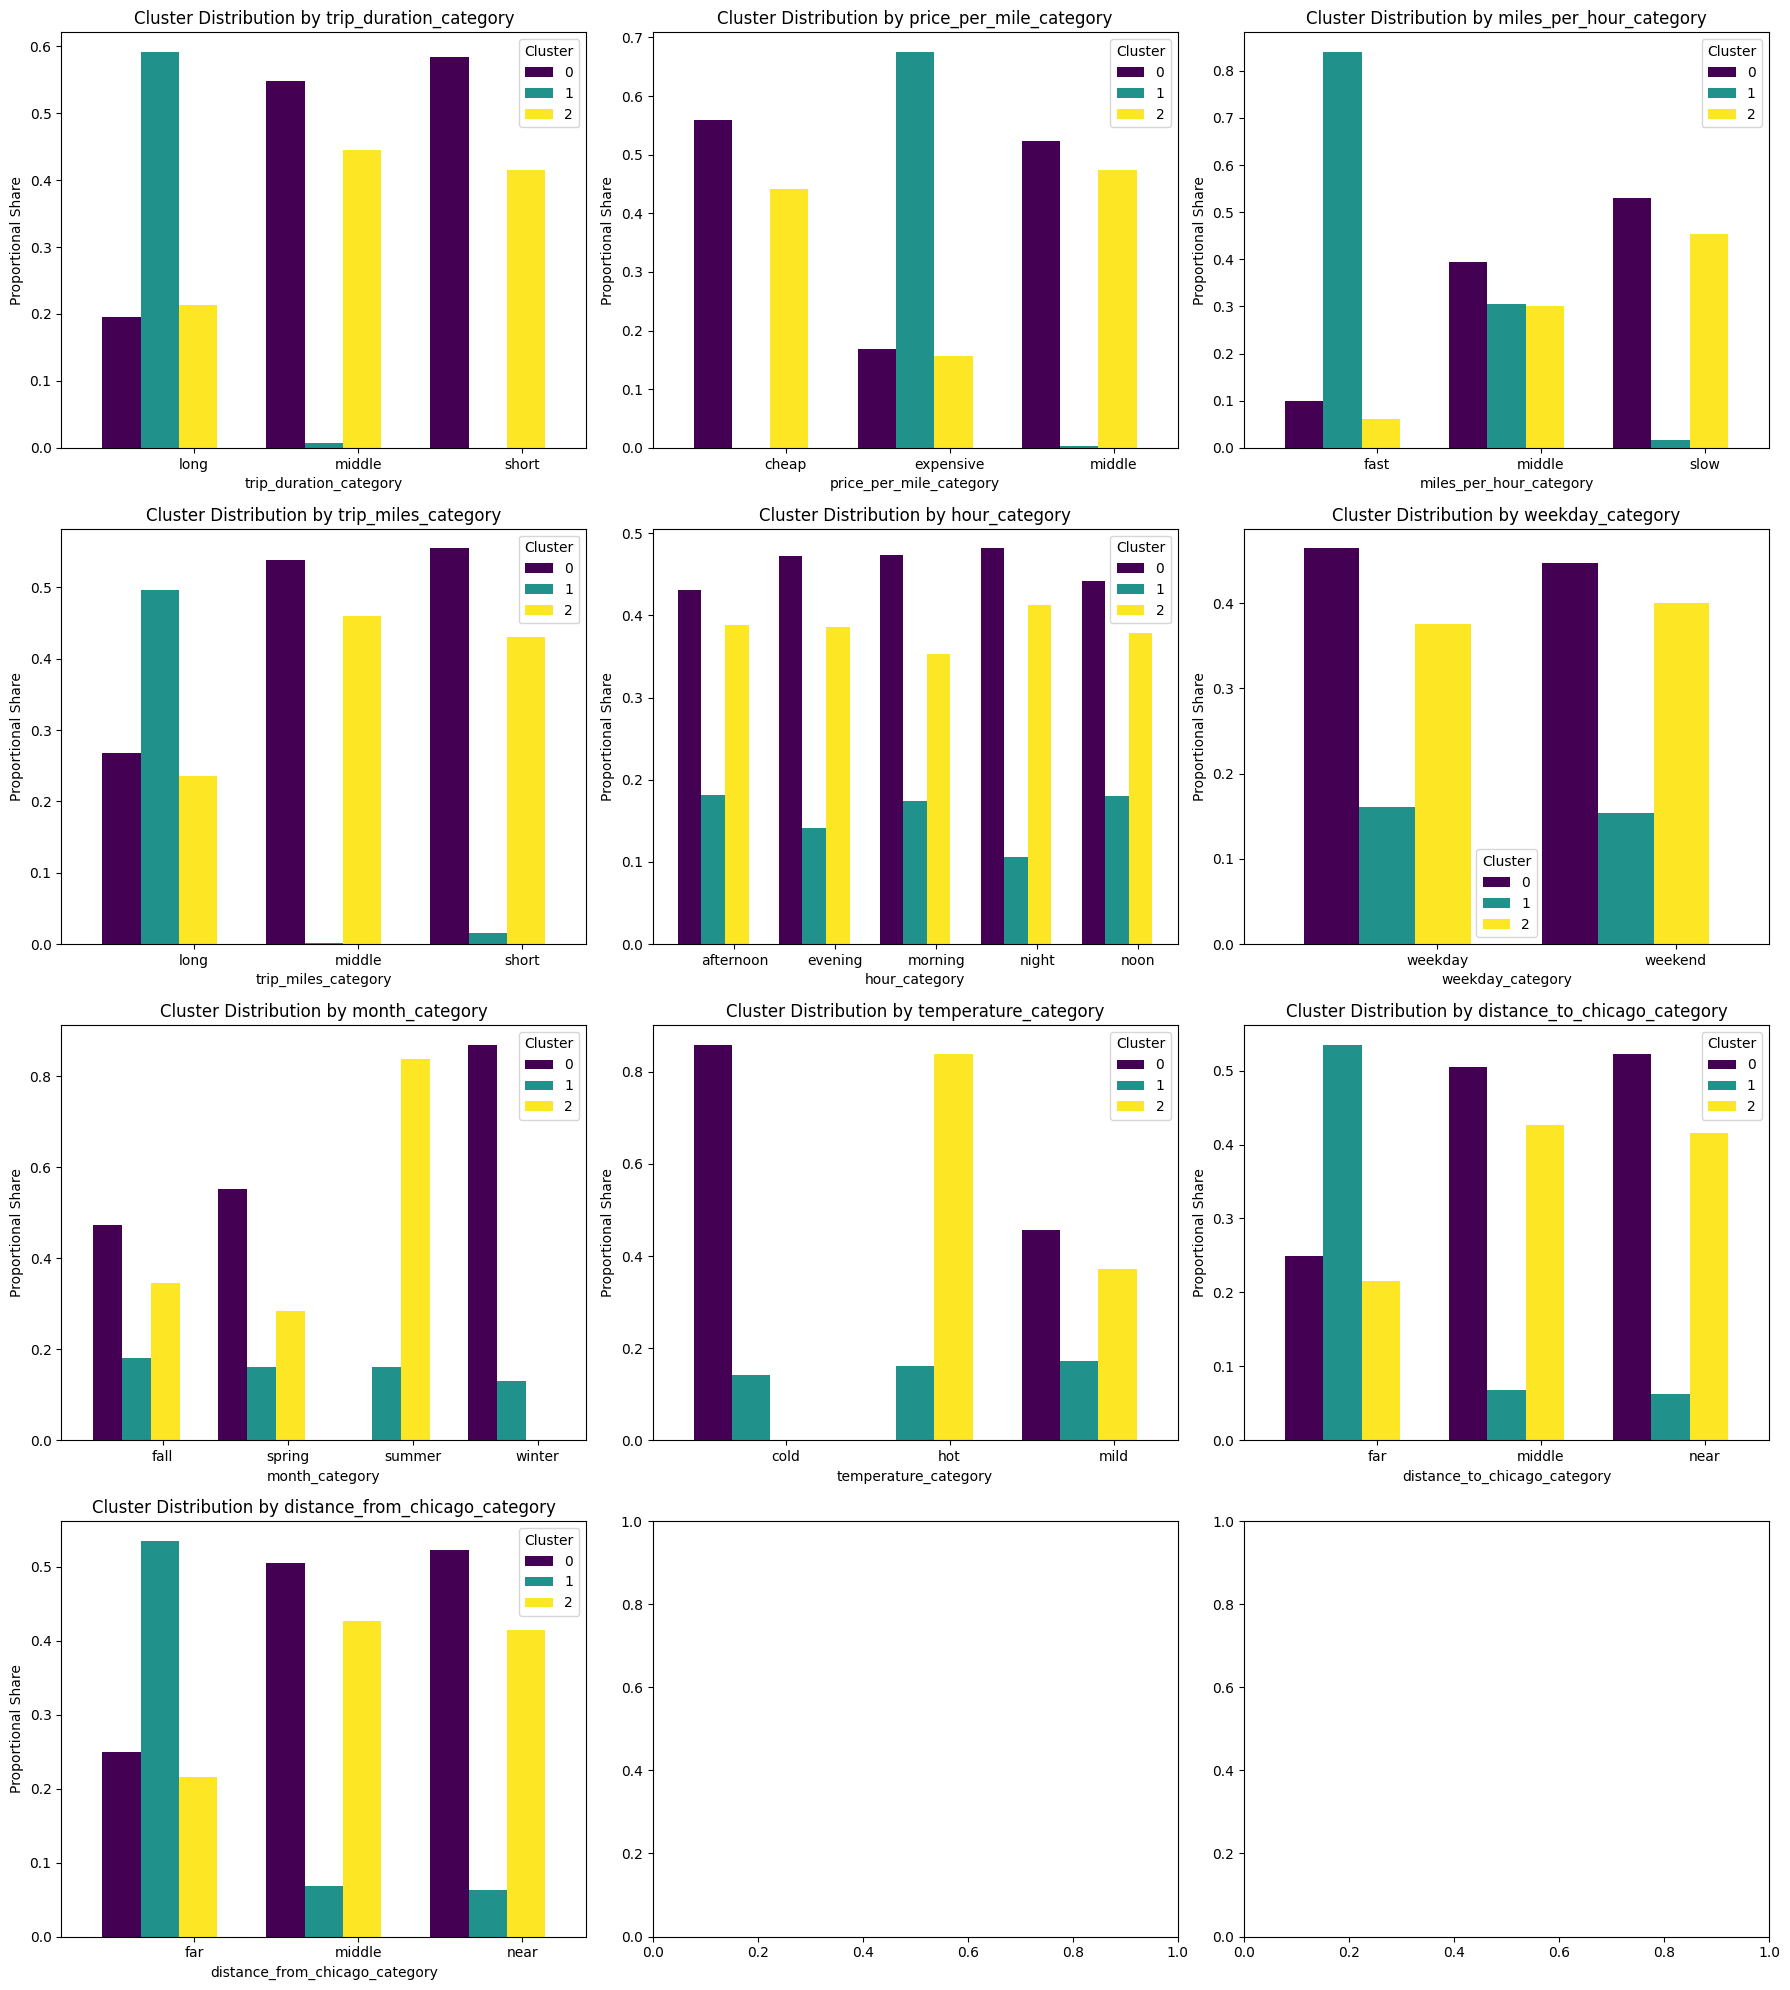

In [36]:
generated_categories = [
    'trip_duration_category',
    'price_per_mile_category',
    'miles_per_hour_category',
    'trip_miles_category',
    'hour_category',
    'weekday_category',
    'month_category',
    'temperature_category',
    'distance_to_chicago_category',
    'distance_from_chicago_category'
]

fig, axes = plt.subplots(4, 3, figsize=(18, 20))

for i, category in enumerate(generated_categories):
    ax = axes[i // 3, i % 3]
    
    cross_tab = pd.crosstab(Cluster_all_knn[category], Cluster_all_knn['clusters'], normalize='index')

    cross_tab.plot(kind='bar', stacked=False, position=0.8, width=0.7, colormap='viridis', ax=ax)
    
    ax.set_title(f'Cluster Distribution by {category}')
    ax.set_xlabel(category)
    ax.set_ylabel('Proportional Share')
    ax.legend(title='Cluster')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

## Soft Clustering

In [37]:
gmm = GaussianMixture(n_components=3).fit(X_pca)
labels_soft = gmm.predict(X_pca)

In [38]:
sample_size = int(0.1 * len(X_pca))

random_indices = np.random.choice(len(X_pca), sample_size, replace=False)
X_pca_sample = X_pca[random_indices]
labels_soft_sample = labels_soft[random_indices]

silhouette_score_soft = silhouette_score(X_pca_sample, labels_soft_sample)


#silhouette_score_soft = silhouette_score(X_pca, labels_soft)
print(f"Silhouette Score for 3 clusters: {silhouette_score_soft}")

Silhouette Score for 3 clusters: 0.48413898405840694


In [39]:
Cluster_all_gmm = Cluster_all.copy()
Cluster_all_gmm["clusters"]= labels_soft

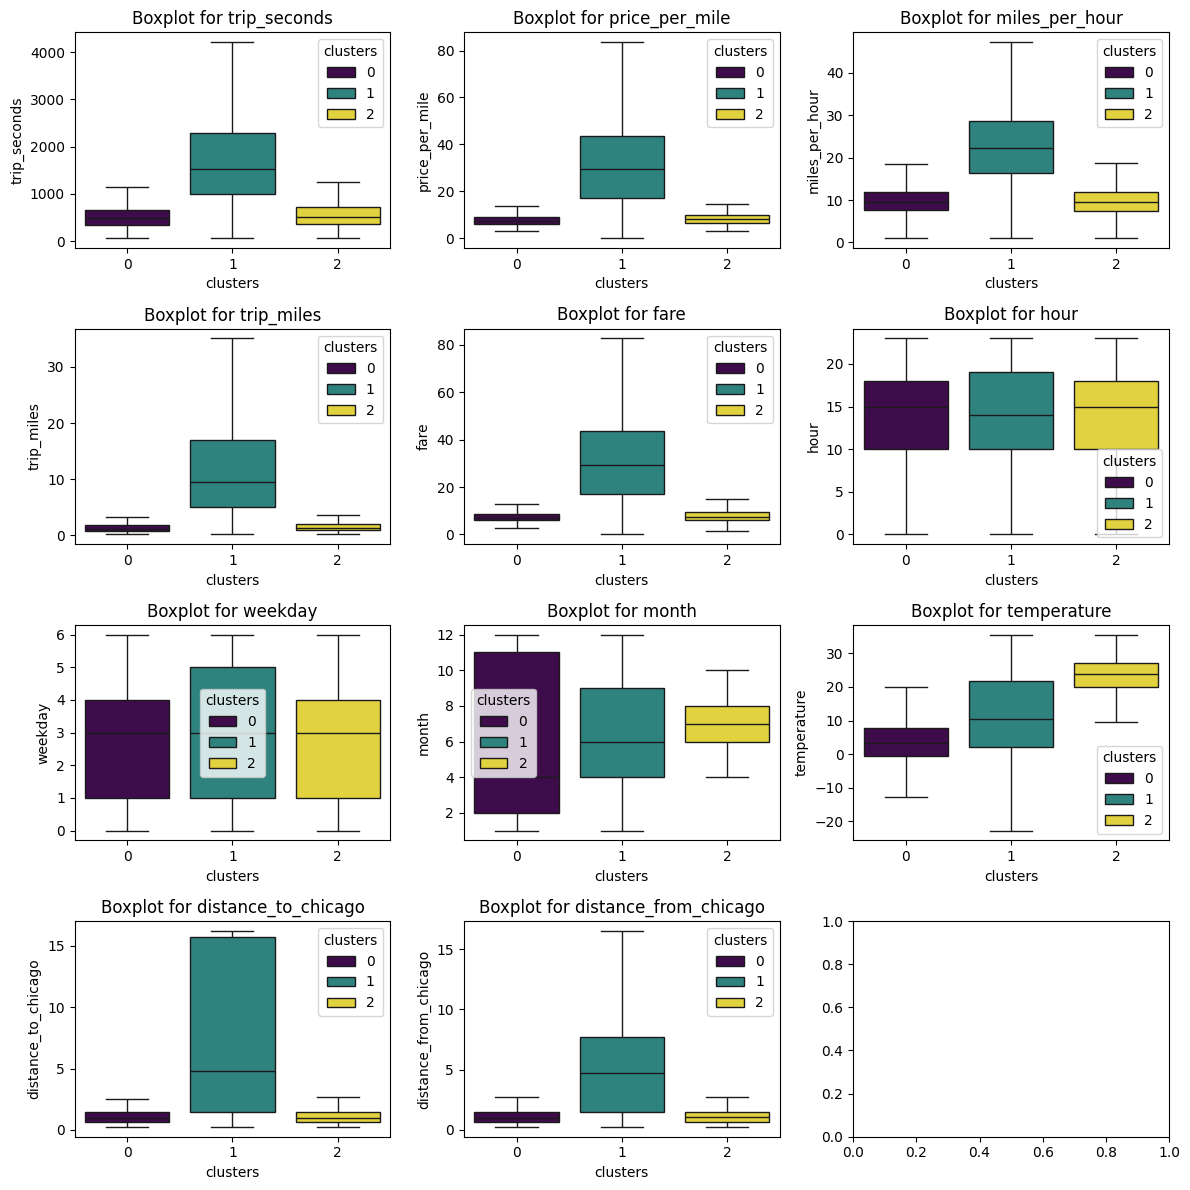

In [40]:
features_soft = features

# Create a 3x3 subplot grid
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 12))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate through features and create boxplots
for i, feature in enumerate(features_soft):
    
    sns.boxplot(x='clusters', y=feature, data=Cluster_all_gmm, hue='clusters', palette='viridis', ax=axes[i], showfliers=False)
    
    # Set subplot title
    axes[i].set_title(f'Boxplot for {feature}')

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

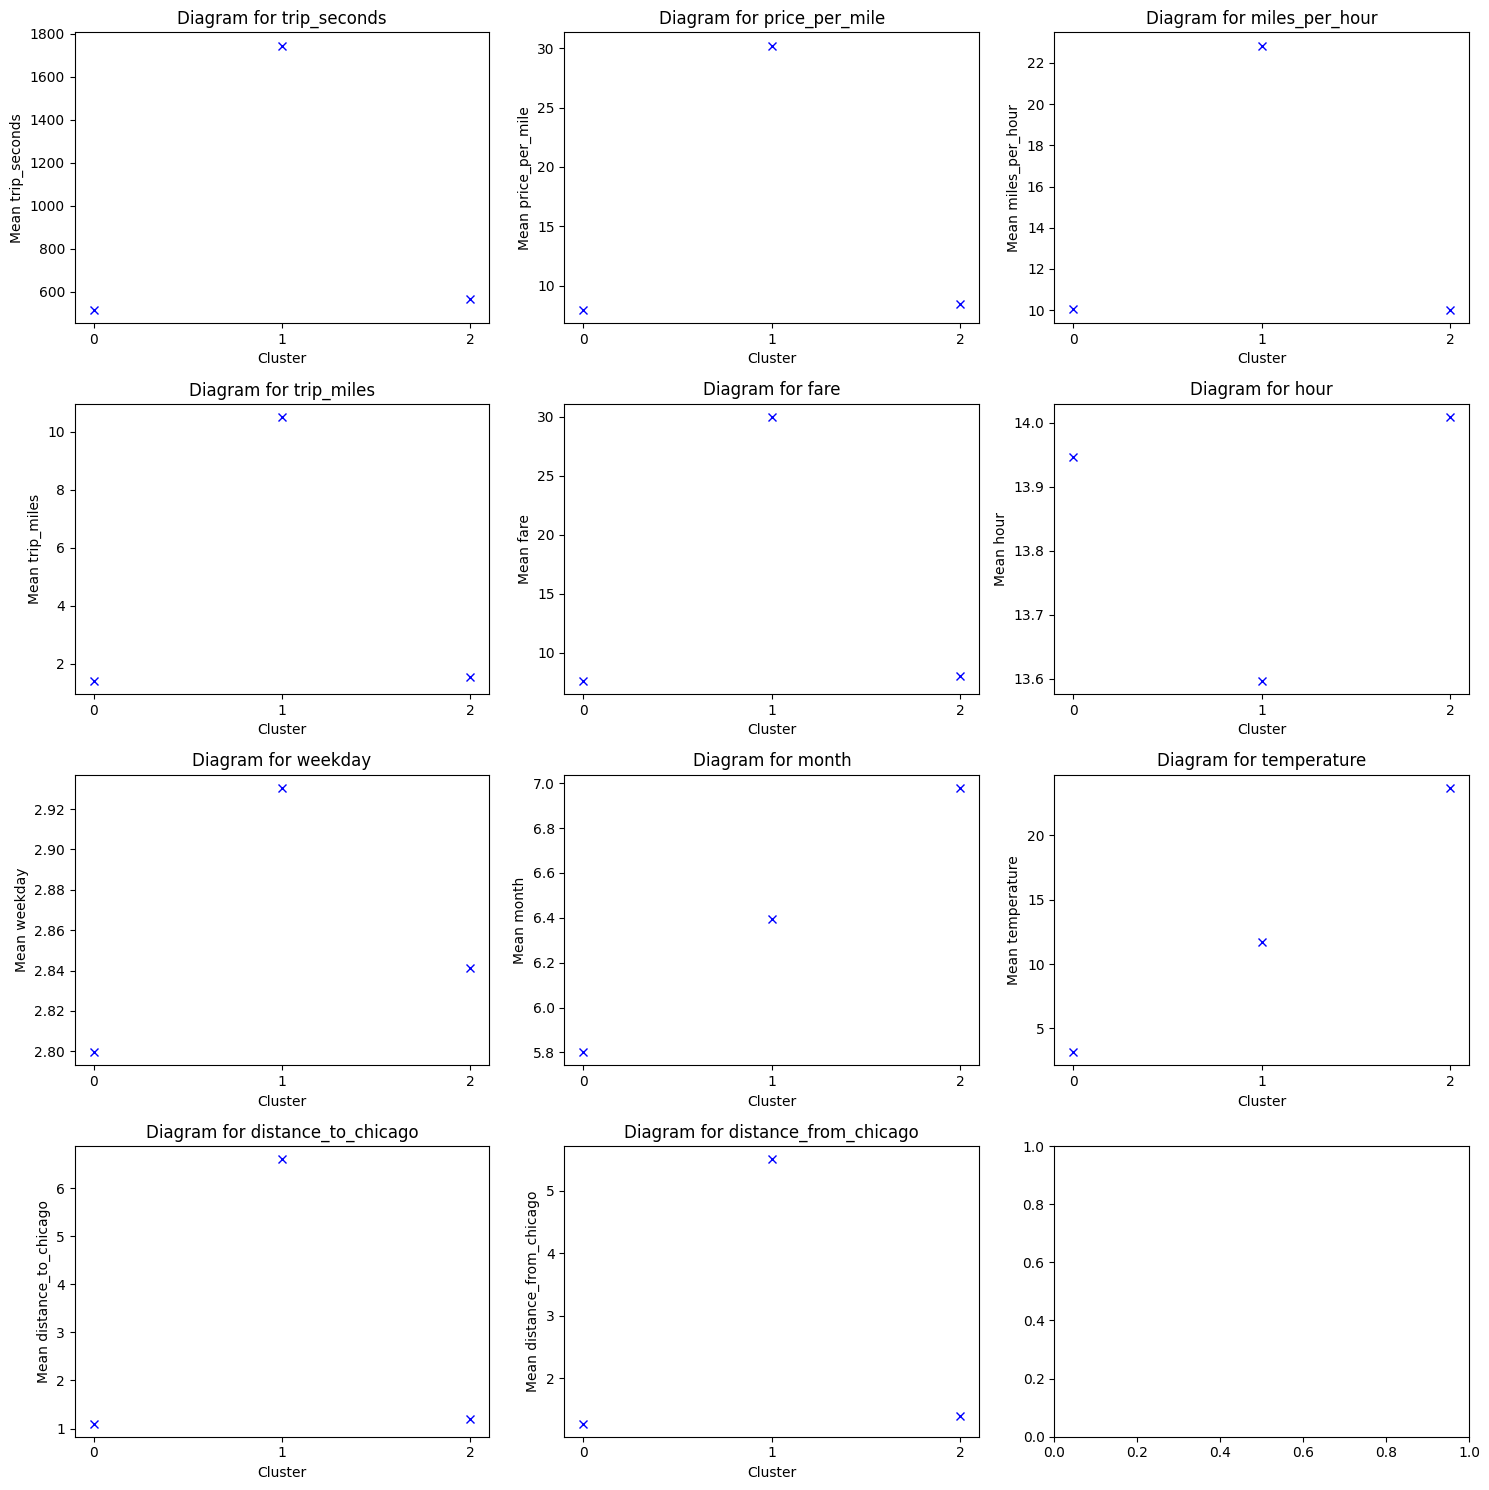

In [41]:
# Features to plot
features_soft = features
cluster_centers = Cluster_all_gmm.groupby('clusters').mean().reset_index()

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))

axes = axes.flatten()


for i, feature in enumerate(features_hard):
    axes[i].plot(cluster_centers['clusters'], cluster_centers[feature], marker='x', linestyle='', color='b', label=f'Feature: {feature}')
    
    axes[i].set_title(f'Diagram for {feature}')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel(f'Mean {feature}')
    axes[i].xaxis.set_major_locator(MultipleLocator(1))

plt.tight_layout()

plt.show()

In [42]:
# Inspect mean values
cluster_centers

clusters  trip_seconds  price_per_mile  miles_per_hour  trip_miles  \
0         0    517.206828        7.961723       10.052778    1.397138   
1         1   1745.412595       30.227199       22.836898   10.517981   
2         2    568.846524        8.443501       10.022922    1.534092   

        fare       hour   weekday     month  temperature  distance_to_chicago  \
0   7.603258  13.946975  2.799498  5.801059     3.140892             1.104691   
1  29.979972  13.596463  2.930413  6.393339    11.749761             6.597457   
2   8.067811  14.009144  2.841288  6.978105    23.690805             1.205145   

   distance_from_chicago  
0               1.277978  
1               5.504043  
2               1.401053

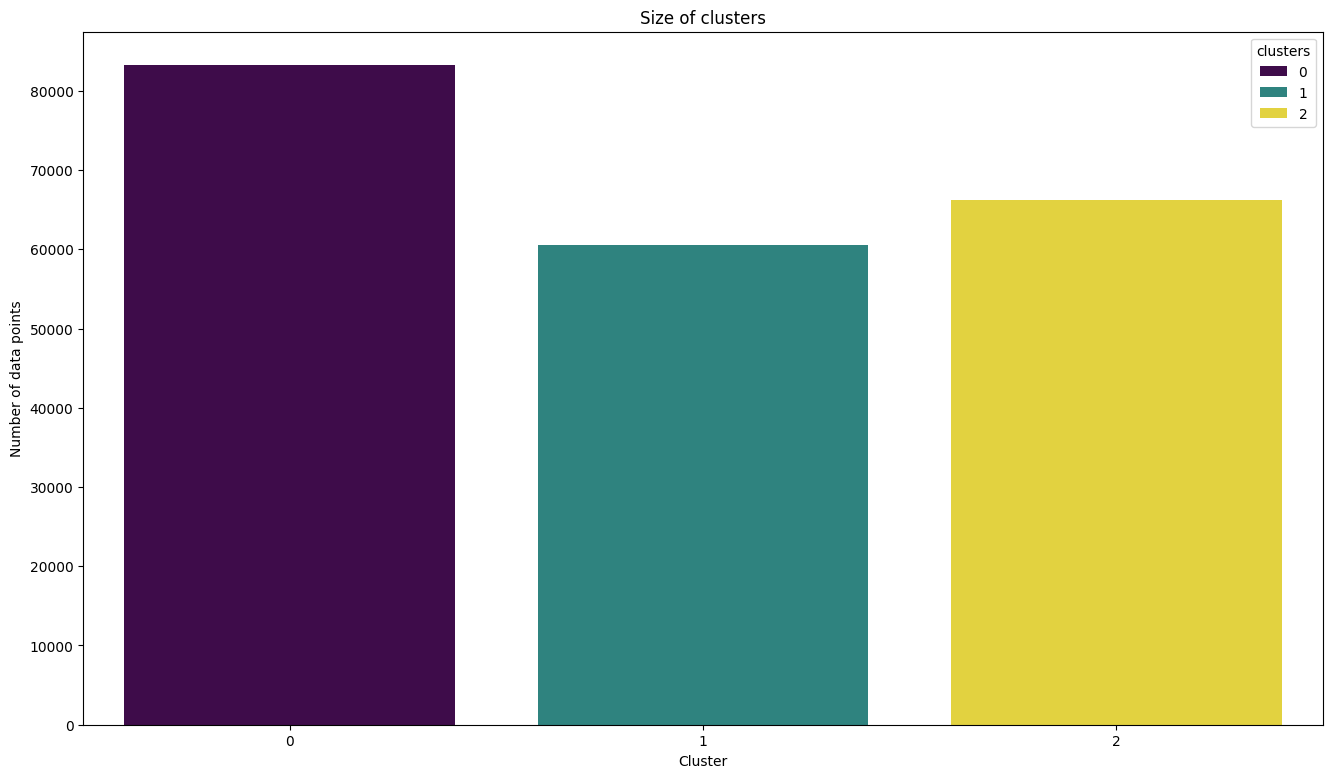

In [43]:
plt.figure(figsize=(16,9))
sns.countplot(data=Cluster_all_gmm, x="clusters", hue="clusters", palette='viridis')
plt.xlabel('Cluster')
plt.ylabel('Number of data points')
plt.title('Size of clusters')
plt.show()

In [44]:
cluster_sizes = Cluster_all_gmm['clusters'].value_counts()
print(cluster_sizes)

clusters
0    83301
2    66271
1    60500
Name: count, dtype: int64


In [45]:
# Trip Duration: long, middle, short
Cluster_all_gmm['trip_duration_category'] = [
    'short' if x < 300 else 'middle' if x < 1000 else 'long' 
    for x in Cluster_all_gmm['trip_seconds']
]

# Price per Mile: expensive, middle, cheap
Cluster_all_gmm['price_per_mile_category'] = [
    'cheap' if x < 9.9 else 'middle' if x < 16.0 else 'expensive' 
    for x in Cluster_all_gmm['price_per_mile']
]

# Miles per Hour: fast, middle, slow
Cluster_all_gmm['miles_per_hour_category'] = [
    'slow' if x < 13 else 'middle' if x < 30 else 'fast' 
    for x in Cluster_all_gmm['miles_per_hour']
]

# Trip Miles: long, middle, short
Cluster_all_gmm['trip_miles_category'] = [
    'short' if x < 1.2 else 'middle' if x < 3.1 else 'long' 
    for x in Cluster_all_gmm['trip_miles']
]

# Hour: night, morning, noon, afternoon, evening
Cluster_all_gmm['hour_category'] = [
    'night' if x < 5 else 
    'morning' if x < 11 else 
    'noon' if x < 14 else 
    'afternoon' if x < 17 else 
    'evening'
    for x in Cluster_all_gmm['hour']
]

# Weekday: weekday, weekend
Cluster_all_gmm['weekday_category'] = [
    'weekend' if day >= 5 else 'weekday' 
    for day in Cluster_all_gmm['weekday']
]

# Month: winter, spring, summer, fall (USA)
Cluster_all_gmm['month_category'] = [
    'winter' if x in [12, 1, 2] else 'spring' if x in [3, 4, 5] else 'summer' if x in [6, 7, 8] else 'fall' 
    for x in Cluster_all_gmm['month']
]

# Temperature: hot, mild, cold
Cluster_all_gmm['temperature_category'] = [
    'cold' if x < 4.0 else 'mild' if x < 22.0 else 'hot' 
    for x in Cluster_all_gmm['temperature']
]

# Distance to Chicago: near, middle, far
Cluster_all_gmm['distance_to_chicago_category'] = [
    'near' if x < 0.7 else 'middle' if x < 3 else 'far' 
    for x in Cluster_all_gmm['distance_to_chicago']
]

# Distance from Chicago: near, middle, far
Cluster_all_gmm['distance_from_chicago_category'] = [
    'near' if x < 0.7 else 'middle' if x < 3 else 'far' 
    for x in Cluster_all_gmm['distance_to_chicago']
]

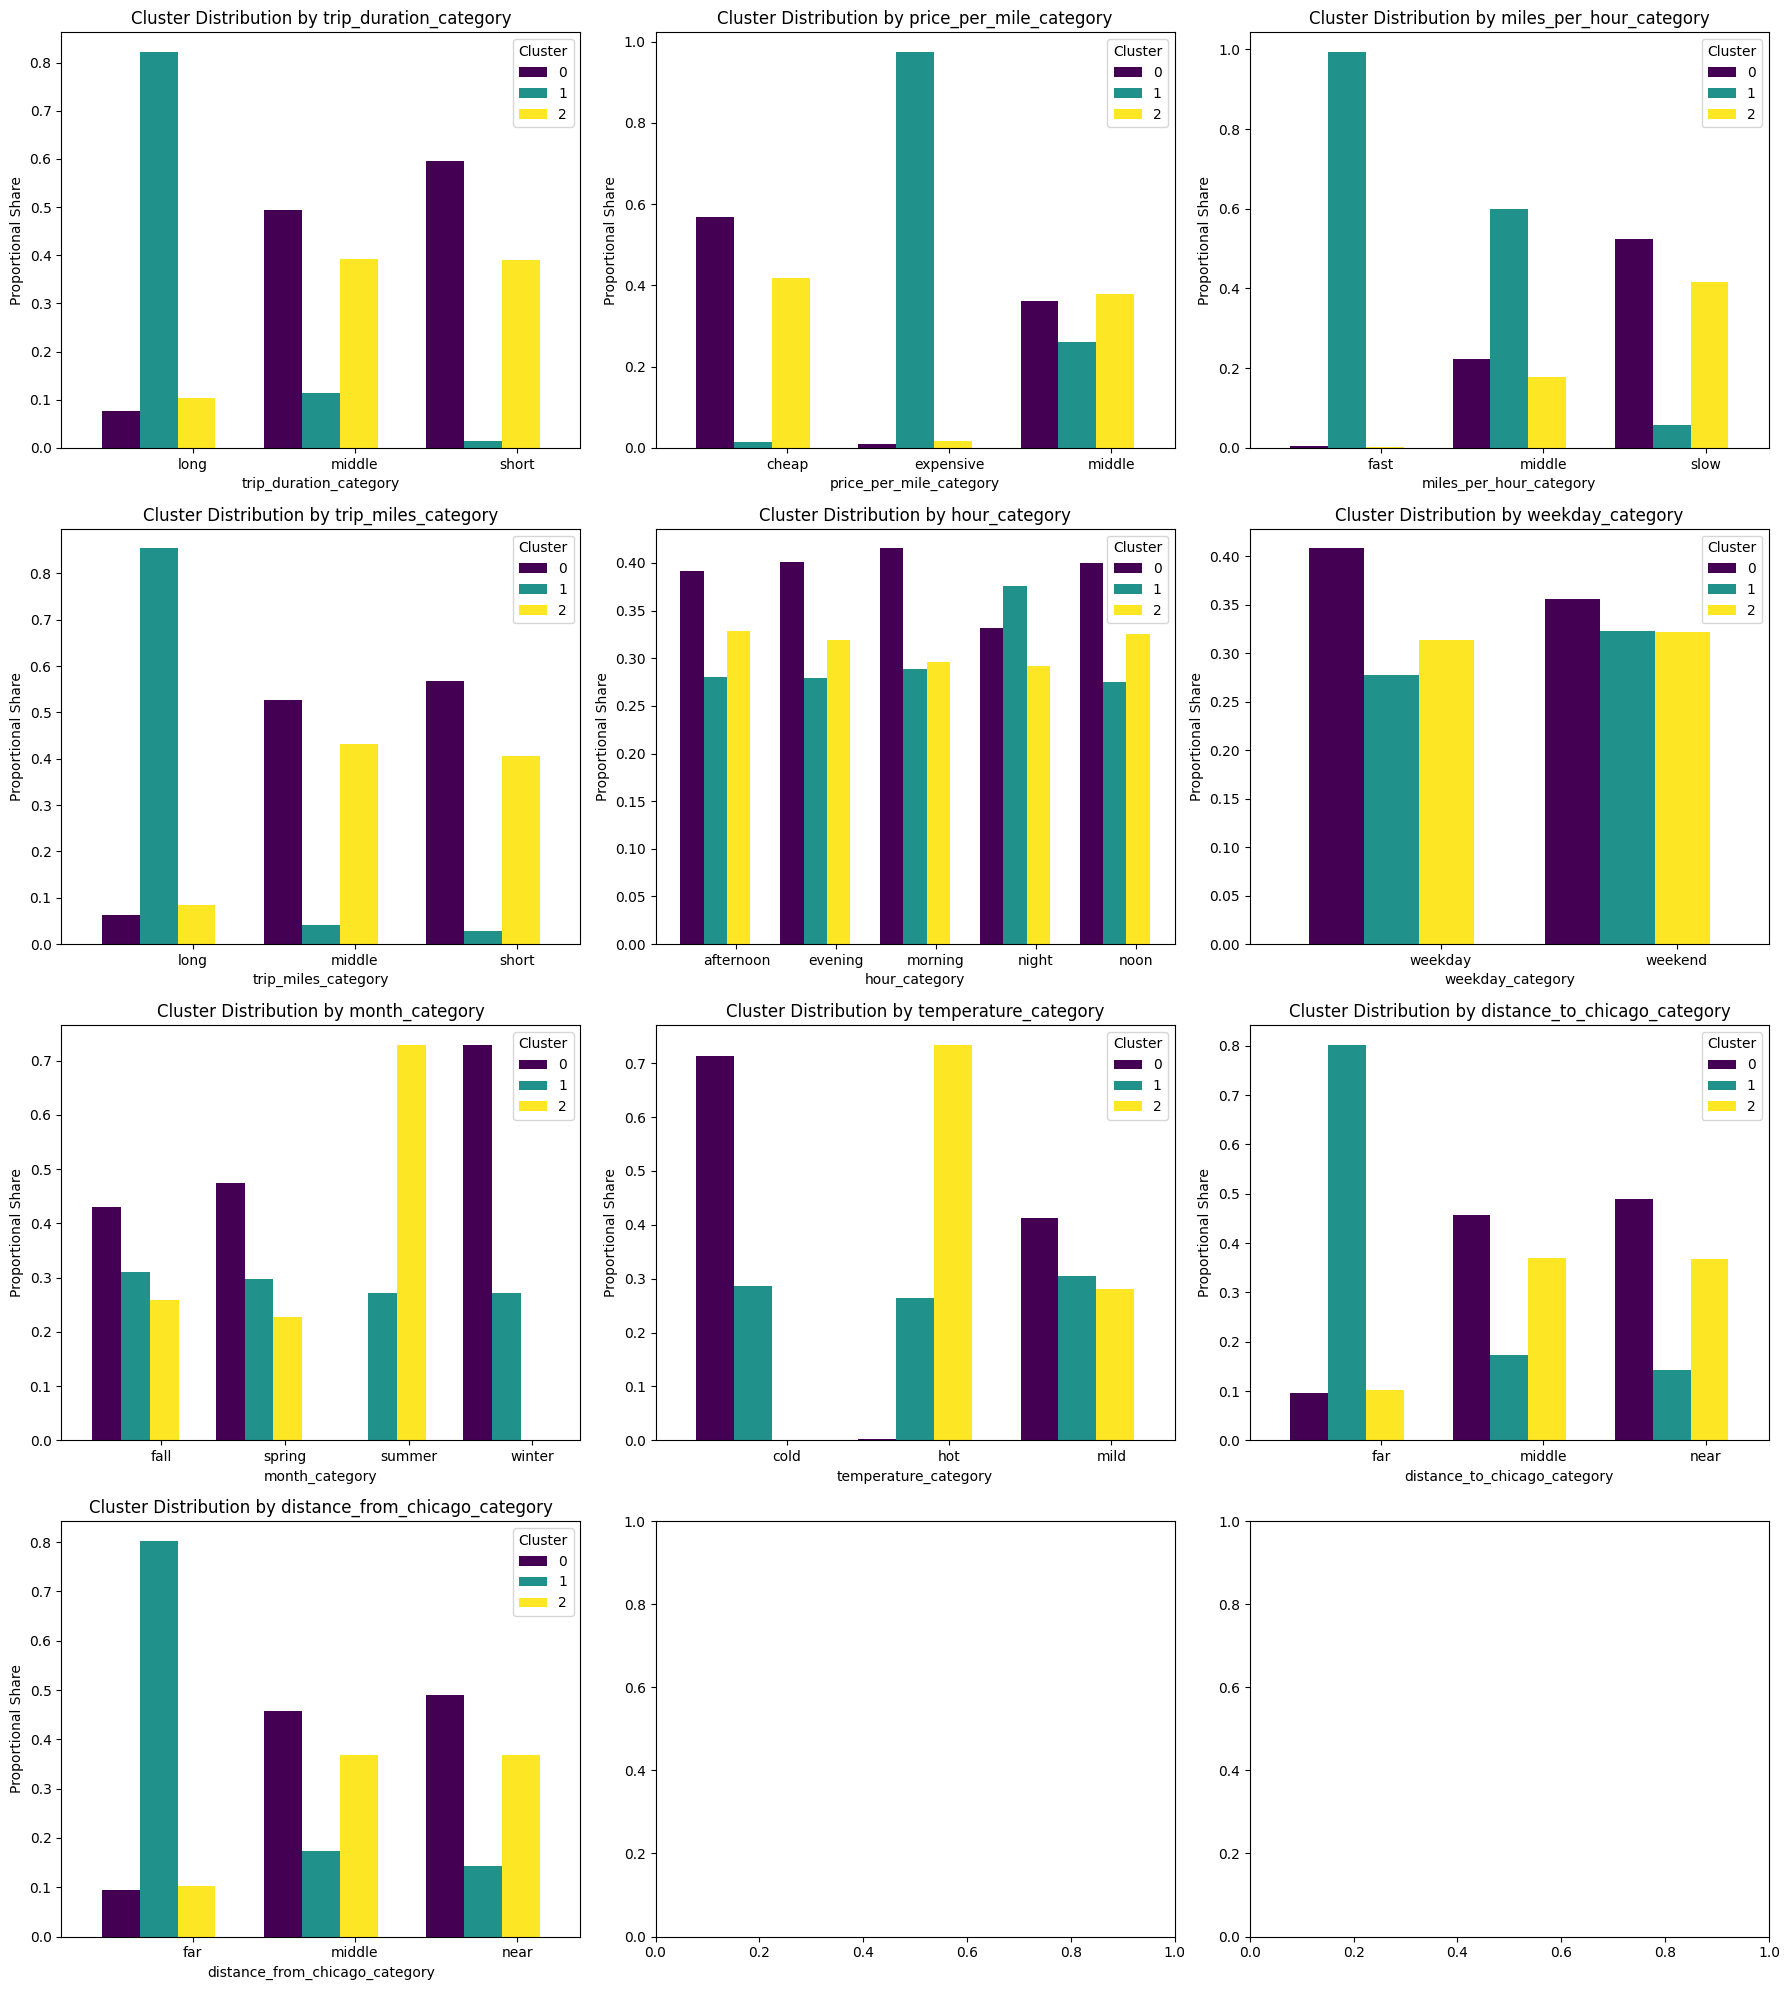

In [46]:
fig, axes = plt.subplots(4, 3, figsize=(18, 20))

for i, category in enumerate(generated_categories):
    ax = axes[i // 3, i % 3]
    
    cross_tab = pd.crosstab(Cluster_all_gmm[category], Cluster_all_gmm['clusters'], normalize='index')
    
    cross_tab.plot(kind='bar', stacked=False, position=0.8, width=0.7, colormap='viridis', ax=ax)

    ax.set_title(f'Cluster Distribution by {category}')
    ax.set_xlabel(category)
    ax.set_ylabel('Proportional Share')
    ax.legend(title='Cluster')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.show()

# Spatial Kernel Density Estimation

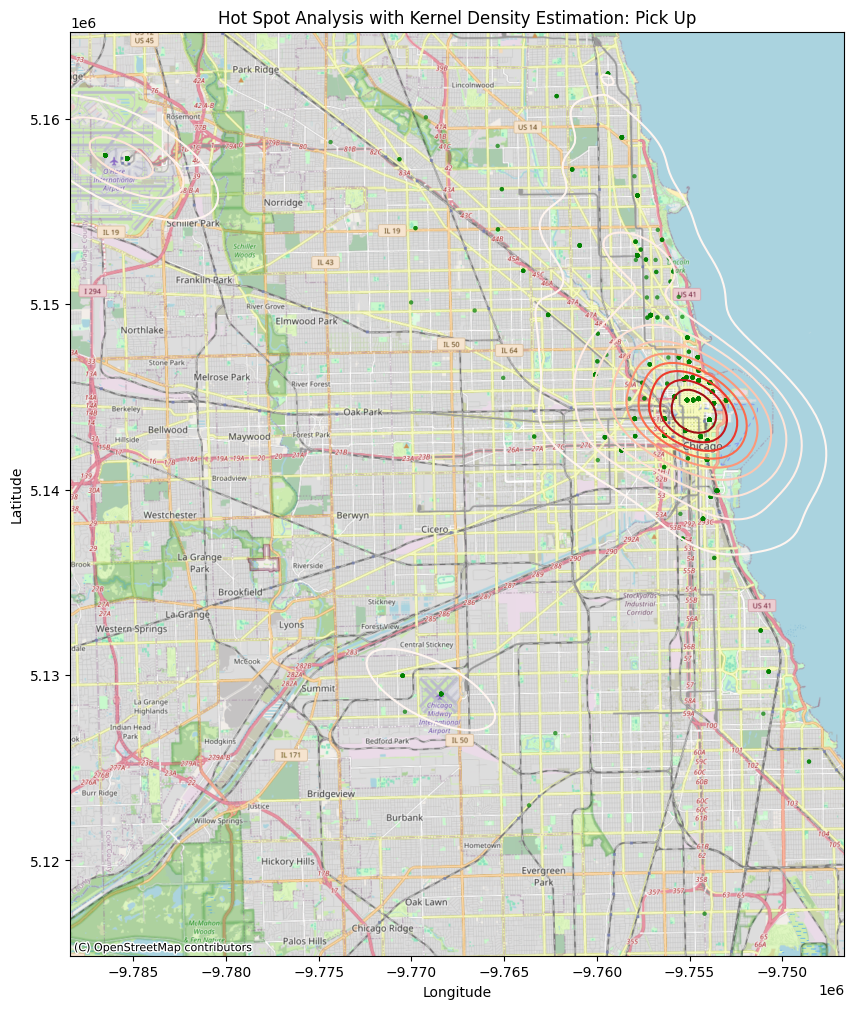

In [47]:
bw_adjust = 1

# Sampling due to computational resources
data = data.sample(n=2000, random_state=42)

gdf = gpd.GeoDataFrame(
    data,
    geometry=[Point(lon, lat) for lon, lat in zip(data['pickup_longitude'], data['pickup_latitude'])],
    crs="EPSG:4326"  # Data locates in a WGS84 Coordinate System
)

# Need to convert the GeoDataFrame to EPSG:3857 for the basemap
gdf = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 12))

gdf.plot(ax=ax, color='green', markersize=10, alpha=0.7, edgecolor='none')

ctx.add_basemap(ax, crs='EPSG:3857', zoom=12, source=ctx.providers.OpenStreetMap.Mapnik)

# Gaussian kernel is default
sns.kdeplot(
    x=gdf.geometry.x, 
    y=gdf.geometry.y, 
    cmap="Reds", 
    bw_adjust=bw_adjust, 
    ax=ax,
    fill=False
)

ax.set_title('Hot Spot Analysis with Kernel Density Estimation: Pick Up')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_aspect('equal')

plt.show()

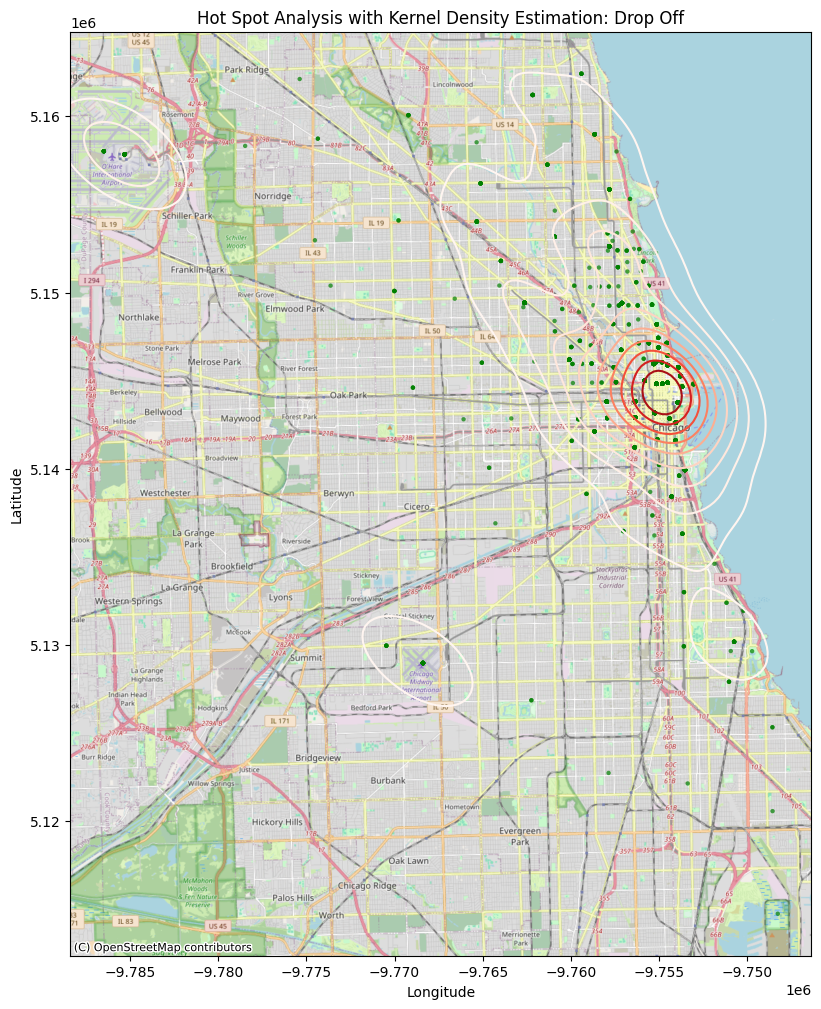

In [48]:
gdf = gpd.GeoDataFrame(
    data,
    geometry=[Point(lon, lat) for lon, lat in zip(data['dropoff_longitude'], data['dropoff_latitude'])],
    crs="EPSG:4326"
)

gdf = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 12))

gdf.plot(ax=ax, color='green', markersize=10, alpha=0.7, edgecolor='none')

ctx.add_basemap(ax, crs='EPSG:3857', zoom=12, source=ctx.providers.OpenStreetMap.Mapnik)

sns.kdeplot(
    x=gdf.geometry.x, 
    y=gdf.geometry.y, 
    cmap="Reds", 
    bw_adjust=bw_adjust, 
    ax=ax,
    fill=False
)

ax.set_title('Hot Spot Analysis with Kernel Density Estimation: Drop Off')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_aspect('equal')

plt.show()